#Initialization
All the code reported below was written by me, except for the network as will be stated.  
Firstly, we import the needed libraries and mount the drive to acces files

In [1]:
import importlib.util
from google.colab import drive
import functools
from typing import Optional, Sequence, Tuple, Union

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
drive.mount('/content/drive')
saving_directory='/content/drive/MyDrive/NN_project_models/' #This path is where the models will be saved after training

Mounted at /content/drive


#SWBN layer implementation
Firstly, since in keras the convention for a rank 4 tensor is $(bs,w,h,c)$ where the dimensions are mini-batch size, width, height, and number of channels respectively, if the input is 4D it is first transposed to be $(c,bs,w,h)$ and then, as suggested in the reference paper, it is reshaped as a rank 2 tensor $X$ in the form $(c,bs \cdot w \cdot h)$.  
If the input tensor has rank 2, it is just transposed, hence the input is always reshaped to be a matrix $X \in \mathbb{R}^{c \times n}$.  
At the end of the algorithm, after applying scaling and shifting using two learnable parameters $\gamma,\beta \in \mathbb{R}^c$, the tensor is reshaped in the form $(bs,w,h,c)$ and then returned as output.

In [2]:
import tensorflow.keras.layers as layers
from keras import backend as K

class SWBN(layers.Layer):
  """
  To use this layer, implement a function that changes the whitening learning rate (WLR) alpha
  by calling the function set_alpha(lr).
  When creating this layer, other than the whitening criterion, we can specify
  the desired alpha, and also the desired ratio between alpha and the lr.
  The latter overrules the former, i.e. if the specified WLR and lr do not have the
  specified ratio, then alpha will be changed accordingly. This is done to make 
  both the WLR and the lr decrease in the same way.
  """

  def __init__(self, criterion="fro", alpha=1e-5, alpha_over_lr=1e-4):
    super(SWBN, self).__init__()
    self.criterion=criterion
    self.alpha=tf.Variable(alpha,trainable=False)
    self.alpha_over_lr=alpha_over_lr

  def build(self, input_shape):
    weight_shape = [input_shape[-1], 1]
    # The scale parameter and the shift parameter (model parameters) are
    # initialized to 1 and 0, respectively
    self.gamma = self.add_weight(name='gamma', shape=weight_shape,
      initializer=tf.initializers.ones, trainable=True)
    self.beta = self.add_weight(name='beta', shape=weight_shape,
      initializer=tf.initializers.zeros, trainable=True)
    self.moving_mean = self.add_weight(name='moving_mean',
        shape=weight_shape, initializer=tf.initializers.zeros,
        trainable=False)
    self.moving_variance = self.add_weight(name='moving_variance',
        shape=weight_shape, initializer=tf.initializers.ones,
        trainable=False)
    self.whitening_matrix = self.add_weight(name='whitening_matrix', 
                          shape=(weight_shape[0],weight_shape[0]),initializer=tf.initializers.identity,
                          trainable=False)

    #This variable tracks the profile of the whitening criteria we want to minimize, given by Eq. (2) of the report
    self.train_loss=tf.Variable([[0.]],shape=(1,None),trainable=False)

  #Function called from the model to keep the ration alpha/lr constant, i.e. make alpha decrease as the lr
  def set_alpha(self,lr):
      self.alpha.assign(lr*self.alpha_over_lr)
    
  # Momentum is used to govern the aggregation over past mean and variance estimates
  def assign_moving_average(self, variable, value):
    momentum = 0.95
    avg = (1.0 - momentum) * value + momentum * variable
    return variable.assign(avg)
  
  #This method implements the update of the whitening matrix w according to Eq. (4) of the report
  def assign_white_matrix(self, w, cov_matrix, alpha=1e-5):
    w_sigma_wT = w @ cov_matrix @ tf.transpose(w) 
    I = tf.eye(cov_matrix.shape[0])
    upper= (w_sigma_wT - I) @ w

    if(self.criterion == "fro"):
      inv=tf.norm(I-w_sigma_wT, ord=self.criterion, axis=[0,1])
      delta = upper @ cov_matrix / inv
    elif(self.criterion == "kl"):
      delta=upper
    else:
      raise ValueError('Criterion should be either fro or kl, instead found {}'.format(self.criterion))
      
    value = w - alpha*delta
    value = 0.5 * (value+tf.transpose(value))
    return w.assign(value)

  @tf.function
  def call(self, inputs, training):
    #assuming the data are in the channel_last format
    shape = K.int_shape(inputs)
    if len(shape) == 4:
      w, h, c = shape[1:]
    elif len(shape) == 2:
      w, h, c = 1, 1, shape[-1]
      inputs = tf.expand_dims(inputs, 1)
      inputs = tf.expand_dims(inputs, 1)
    else:
      raise ValueError('shape not support:{}'.format(shape))

    #bs is the batch size
    #w,h,c are width, height, number of channels respectively
    #the input is in the standard keras form (bs,w,h,c)
    bs = tf.shape(inputs)[0]
    
    #we transpose the input so that it is now (c,bs,w,h)
    x_t = tf.transpose(inputs, (3, 0, 1, 2))

    # and flatten it to become (c,bs*w*h). If the input was 2d, i.e. (bs,c) then x_flat will just be its transpose (c,bs)
    x_flat = tf.reshape(x_t, (c, -1))
    
    if training:
      #This first block of code computes the batch mean and variance, and updates them
      batch_mean = tf.reduce_mean(x_flat, axis=1, keepdims=True)
      batch_variance = tf.reduce_mean(tf.math.squared_difference(
          x_flat, tf.stop_gradient(batch_mean)), axis=1, keepdims=True)
      
      mean_update = self.assign_moving_average(
          self.moving_mean, batch_mean)
      variance_update = self.assign_moving_average(
          self.moving_variance, batch_variance)
      mean, variance = batch_mean, batch_variance
      self.add_update(mean_update)
      self.add_update(variance_update)
      
      #Here data is normalized, i.e. we subtract the mean and divide by the sqrt of the variance + eps
      X_s = tf.nn.batch_normalization(
              x_flat, mean, variance, offset=None, scale=None, variance_epsilon=1e-8,
              )
      #This is the sample covariance matrix, used in the method "assign_white_matrix" to compute the update deltaW of Eq. (4)
      cov_matrix = tf.matmul(X_s, X_s, transpose_b=True) / (tf.cast(bs*w*h, tf.float32))

      matrix_update = self.assign_white_matrix(
          self.whitening_matrix, cov_matrix, alpha=self.alpha)

      self.add_update(matrix_update)
    
      #update the criterion loss to later plot the profile
      w_sigma_wT = self.whitening_matrix @ cov_matrix @ tf.transpose(self.whitening_matrix)
      if self.criterion == 'fro':
          norm = 0.5*float(tf.norm(tf.eye(cov_matrix.shape[0]) - w_sigma_wT ))
      elif self.criterion == 'kl':
          norm= 0.5*float(tf.linalg.trace(w_sigma_wT) - tf.math.log(tf.linalg.det(w_sigma_wT)) - c)

      self.train_loss.assign(tf.concat([self.train_loss,[[norm]]],axis=1))
    else:
      mean, variance = self.moving_mean, self.moving_variance
      X_s = tf.nn.batch_normalization(
              x_flat, mean, variance, offset=None, scale=None, variance_epsilon=1e-8,
              )

    #Here, we  whiten the data and collect the whitened feature
    X_w = self.whitening_matrix @ X_s
    
    #We apply scale and shift to the whitened data
    output = X_w * self.gamma + self.beta

    #Finally, we reshape the data back to the original shape
    output = tf.reshape(output, (c, bs, w, h))
    output = tf.transpose(output, [1, 2, 3, 0])
    if w == 1:
      output = tf.squeeze(output, 1)
    if h == 1:
      output = tf.squeeze(output, 1)
    return output

#Resnet model

The code in the next cell is taken from https://github.com/google-research/diffstride/tree/main/diffstride but with some modifications.  
The network initially had pooling layers after $1 \times 1$ convolutions, for learnable strides purposes. These were removed and classical convolution was used in their place with fixed strides.  
Moreover, since the WLR had to decrease according to the learning rate, and since the lr cannot be accessed directly from the SWBN layer, the model has to check when the lr changes during training and a method is called to keep $\frac{\alpha}{lr}$ constant in each SWBN layer.  
Finally, an attribute was added to the model to decide whether to use standard Batch Normalization or SWBN, and one to track the lr.  
My contribution to the code will be stated in dedicated comments below

In [3]:
# coding=utf-8
# Copyright 2022 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Number = Union[float, int]
Stride = Union[Number, Tuple[Number, Number]]


def data_format(channels_first: bool = True) -> str:
  return 'channels_first' if channels_first else 'channels_last'


def conv2d(
    *args, channels_first: bool = True, weight_decay: float = 0.0, **kwargs):
  return tf.keras.layers.Conv2D(
      *args,
      kernel_initializer='he_normal',
      kernel_regularizer=tf.keras.regularizers.L2(weight_decay),
      data_format=data_format(channels_first),
      use_bias=False,
      **kwargs)

#My contribution: modified this existing method to support both SWBN and BN
def batch_norm(channels_first: bool = True, swbn_on: bool=False, **kwargs):
  axis = 1 if channels_first else 3
  if swbn_on:
    return SWBN(criterion="kl", alpha=1e-5, alpha_over_lr=1e-4)
  return tf.keras.layers.BatchNormalization(axis=axis, momentum=0.95,epsilon=1e-8, **kwargs) #set eps and the momentum to the same value as in the SWBN layer.
                                                                                            #The momentum chosen here is the one used in the moving average update.


class ResidualLayer(tf.keras.layers.Layer):
  """A generic residual layer for Resnet, using the pre-act formulation.

  The pre-act formulation applies batch norm and non-linearity before the first
  conv.
  """

  def __init__(self,
               filters: int,
               kernel_size: int,
               strides: Stride = (1, 1),
               project: bool = False,
               channels_first: bool = True,
               weight_decay: float = 5e-3,
               swbn_on: bool = False,
               **kwargs):
    super().__init__(**kwargs)
    #My contribution: removed the pooling operations

    # If we are in an Id Layer there is no striding of any kind.
    strides = (1, 1) if not project else strides
    conv_strides = strides

    self._strided_conv = conv2d(
        filters, kernel_size, strides=conv_strides, padding='same',
        channels_first=channels_first, weight_decay=weight_decay)

    # The second convolution is a regular one with no strides, no matter what.
    self._unstrided_conv = conv2d(
        filters, kernel_size, strides=(1, 1), padding='same',
        channels_first=channels_first, weight_decay=weight_decay)

    self._bns = tuple(batch_norm(channels_first, swbn_on) for _ in range(2))

    self._shortcut_conv = None
    if project:
      self._shortcut_conv = conv2d(
          filters, kernel_size=1, strides=conv_strides, padding='same',
          channels_first=channels_first, weight_decay=weight_decay)

  def call(self, inputs: tf.Tensor, training: bool = True) -> tf.Tensor:
    shortcut_x = inputs

    x = self._bns[0](inputs, training=training)
    x = tf.nn.relu(x)
    x = self._strided_conv(x)

    x = self._bns[1](x, training=training)
    x = tf.nn.relu(x)
    x = self._unstrided_conv(x)

    if self._shortcut_conv is not None:
      shortcut_x = self._shortcut_conv(shortcut_x)

    return x + shortcut_x


class ResnetBlock(tf.keras.Sequential):
  """A block of residual layers sharing the same number of filters.

  The first residual layer of the block and only this one might be strided.
  This parameter is controlled by the `project_first` parameters.

  The kwargs are passed down to the ResidualLayer.
  """

  def __init__(self,
               filters: int,
               strides: Stride,
               num_layers: int = 2,
               project_first: bool = True,
               swbn_on : bool = False,
               **kwargs):
    residual_fn = functools.partial(
        ResidualLayer, filters=filters, strides=strides, swbn_on=swbn_on, **kwargs)
    blocks = [residual_fn(project=True)] if project_first else []
    num_left_layers = num_layers - int(project_first)
    blocks.extend([residual_fn(project=False) for i in range(num_left_layers)])
    super().__init__(blocks)

#My contribution: inherit from tf.keras.Model instead of tf.keras.Sequential to customize the call method to manage alpha.
class Resnet(tf.keras.Model):
  """A generic Resnet class, using the pre-activation implementation.

  Depending on the number of blocks and the used filters, it can easily
  instantiate a Resnet18 or Resnet56.

  The kwargs are passed down to the ResnetBlock layer.
  """

  def __init__(self,
               filters: Sequence[int],
               strides: Sequence[Stride],
               num_output_classes: int,
               output_activation: Optional[str] = None,
               id_only: Sequence[int] = (),
               channels_first: bool = True,
               weight_decay: float = 5e-3,
               swbn_on: bool = False,
               **kwargs):
    super().__init__()
    if len(filters) != len(strides):
      raise ValueError(f'The number of `filters` ({len(filters)}) should match'
                       f' the number of strides ({len(strides)})')
    df = data_format(channels_first)
    self.layers_ = [
        tf.keras.layers.Permute((3, 1, 2)) if channels_first else None,

        #My contribution: Data augmentation added
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomTranslation(0.15,0.15),

        conv2d(filters[0], 3, padding='same',
               strides=strides[0],
               channels_first=channels_first, weight_decay=weight_decay),
    ]
    #My contribution: inheriting now from Model, the name of the variable storing the layers
    #is changed to layers_, otherwise it gives an error since layers cannot be used.
    for i, (num_filters, stride) in enumerate(zip(filters[1:], strides[1:])):
      self.layers_.append(ResnetBlock(filters=num_filters,
                                strides=stride,
                                project_first=(i not in id_only),
                                channels_first=channels_first,
                                weight_decay=weight_decay,
                                swbn_on=swbn_on,
                                **kwargs))
    self.layers_.extend([
        batch_norm(channels_first,swbn_on=swbn_on),
        tf.keras.layers.ReLU(),
        tf.keras.layers.GlobalAveragePooling2D(data_format=df),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            num_output_classes,
            activation=output_activation,
            kernel_initializer='he_normal',
            kernel_regularizer=tf.keras.regularizers.L2(weight_decay),
            bias_regularizer=tf.keras.regularizers.L2(weight_decay),
            ),
        ])
    self.swbn_on = swbn_on #My contribution: adding this attribute to discriminate between normalizations. This is also passed to the other sub blocks
    self.lr_storage = tf.Variable(0.,trainable=False,name='previous_lr') #My contribution: create a variable to store the learning rate and see when it changes

  #My contribution: implementing the call method to call function to keep Keep alpha/lr constant, called when the lr changes
  def call(self, inputs, training=False):
    if training and self.swbn_on:
      tf.cond(tf.not_equal(self.lr_storage,self.optimizer.lr.lr), lambda:self.alpha_scheduler(), lambda:None) 
    x = inputs
    for layer in self.layers_:
      if layer is not None:
        x = layer(x, training=training)
    return x

  #My contribution: function that manages alpha for each SWBN layer.
  def alpha_scheduler(self):
    self.lr_storage.assign(self.optimizer.lr.lr)
    for layer in self.layers:
      if "resnet" in layer.name:
        for res_layers in layer.layers:
          res_layers._bns[0].set_alpha(self.optimizer.lr.lr)
          res_layers._bns[1].set_alpha(self.optimizer.lr.lr)
      if "swbn" in layer.name:
        layer.set_alpha(self.optimizer.lr.lr)

  #My contribution: function created to have shapes when calling the summary. The usage is "model_name.model().summary()"
  def model(self):
    x = tf.keras.Input(shape=(32, 32, 3))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

#Data loading and learning rate scheduling
Load the CIFAR-10 dataset and set up the optimizer for the learning rate scheduling

In [4]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train=x_train.astype("float32")/255.0;
x_test=x_test.astype("float32")/255.0;
print(x_train.shape)
print(x_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate
    self.iterations = tf.constant([32000.,48000])
    self.lr = tf.Variable(self.initial_learning_rate)
    
  def __call__(self, step):
    lr = tf.cond(tf.greater(step,self.iterations[0]), lambda:self.initial_learning_rate/10.0, lambda:self.initial_learning_rate)
    lr = tf.cond(tf.greater(step,self.iterations[1]), lambda:lr/10.0, lambda:lr)
    self.lr.assign(lr)
    return lr

optimizer = tf.keras.optimizers.SGD(learning_rate=MyLRSchedule(0.1), momentum=0.9)

#Training the model
Create a callback to save the weights of the best model, according to the validation accuracy.  
Choose also whether to use Batch Normalization or SWBN with the flag ```swbn_on```

In [6]:
swbn_on = True

checkpoint_filepath = saving_directory + 'resnet56_swbn/' if swbn_on else saving_directory + 'resnet56_bn/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Specify the parameters to create a ResNetV2-56. Parameters taken from https://github.com/google-research/diffstride/tree/main/diffstride

In [7]:
filters = [16, 16, 32, 64]
strides = [1, 1, 2, 2]
num_classes=10
output_activation = 'softmax'
id_only = []
channel_first = False
weight_decay = 0.0001

resnet56 = Resnet(filters, strides, num_classes, output_activation, id_only, channel_first,
                     weight_decay, swbn_on=swbn_on, num_layers=9, kernel_size=3)
resnet56.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

Train the model for 150 epochs with batch size of 128. Other than saving the weights of the best model, we also save the weights at the end of training, and also the history of training to plot loss and accuracy with the plotting function defined at the beginning.  
Training with BN takes about 1 and a half hour, and about 3 hours are needed with SBWN

In [ ]:
history=resnet56.fit(x_train, y_train, batch_size=128, epochs=150, validation_data=(x_test,y_test),callbacks=[model_checkpoint_callback])
np.save(checkpoint_filepath+ 'trainHistoryDict.npy', history.history)

last_weights_path = saving_directory + 'resnet56_swbn_last/' if swbn_on else saving_directory + 'resnet56_bn_last/'
resnet56.save_weights(last_weights_path)

Print the maximum achieved accuracy and the epoch at which it occurred

In [ ]:
print(np.amax(history.history['val_accuracy']))
print(np.argmax(history.history['val_accuracy'])+1)

#Plot model history
Load and plot the accuracy and loss over test and training set

In [8]:
# we first define a plotting helper function
def plothist(hist):
    plt.plot(hist['accuracy'])
    plt.plot(hist['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Average using best models:  0.9349800109863281
Average using last models:  0.9335200071334839
Plot of the history of the best model:


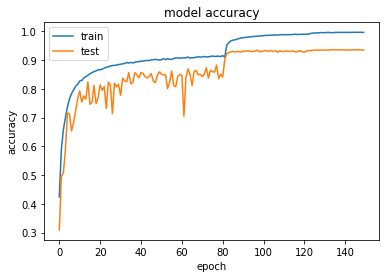

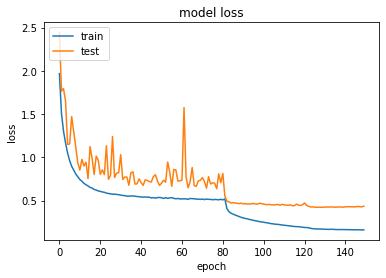

In [9]:
swbn_on = False
loading_directory = '/content/drive/MyDrive/NN_project_models/Stochastic Whitening Batch Normalization/' if swbn_on \
else '/content/drive/MyDrive/NN_project_models/Batch Normalization/'
acc = []
for i in range(5):
  h=np.load(loading_directory +'run'+ str(i+1) + '/resnet56/trainHistoryDict.npy',allow_pickle=True).item()
  acc.append(np.amax(h['val_accuracy']))
print('Average using best models: ',np.mean(acc))

acc = []
for i in range(5):
  h=np.load(loading_directory +'run'+ str(i+1) + '/resnet56/trainHistoryDict.npy',allow_pickle=True).item()
  acc.append(h['val_accuracy'][-1])
print('Average using last models: ',np.mean(acc))

print('Plot of the history of the best model:') #The best model usign SWBN in the one in run5. Using BN, the best is on run 3
h=np.load(loading_directory +'run5/'+'resnet56/trainHistoryDict.npy',allow_pickle=True).item() if swbn_on else \
np.load(loading_directory +'run3/'+'resnet56/trainHistoryDict.npy',allow_pickle=True).item()
plothist(h)

#Plot whitening loss

We can also plot the profile of the chosen Criterion during training, i.e we can plot $C_{KL}=\frac{1}{2}(tr(W\Sigma_xW^T)-ln \ det(W\Sigma_xW^T))$ or $C_{Fro}=\frac{1}{2}||I-W\Sigma_xW^T||_{Fro}$  
To make the plots clearer, we plot the loss over the epochs instead of the iterations. We first load a model, and then plot

In [10]:
loading_directory = '/content/drive/MyDrive/NN_project_models/Stochastic Whitening Batch Normalization/run5/'

filters = [16, 16, 32, 64]
strides = [1, 1, 2, 2]
num_classes=10
output_activation = 'softmax'
id_only = []
channel_first = False
weight_decay = 0.0001

resnet56 = Resnet(filters, strides, num_classes, output_activation, id_only, channel_first,
                     weight_decay, swbn_on=True, num_layers=9, kernel_size=3)

resnet56.load_weights(loading_directory + 'resnet56_last/') #load the last model to have the loss until the end of training

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_translation_1 (Rando  (None, 32, 32, 3)        0         
 mTranslation)                                                   
                                                                 
 conv2d_58 (Conv2D)          (None, 32, 32, 16)        432       
                                                                 
 resnet_block_3 (ResnetBlock  (None, 32, 32, 16)       47506     
 )                                                               
                                                                 
 resnet_block_4 (ResnetBlock  (None, 16, 16, 32)       181714

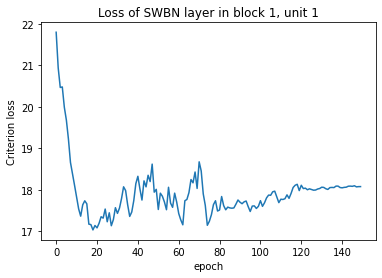

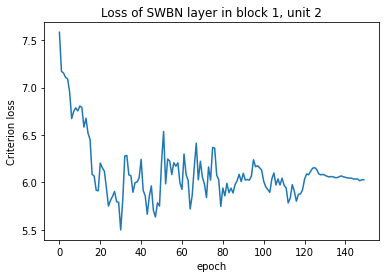

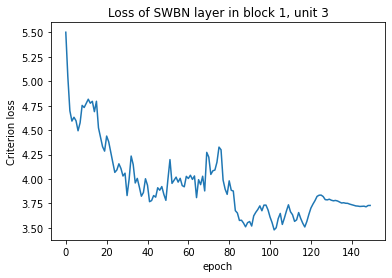

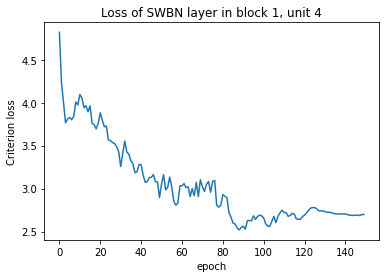

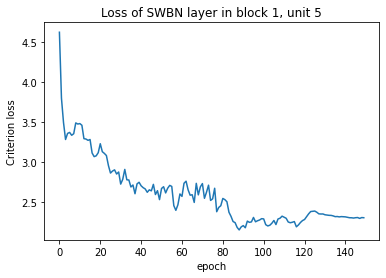

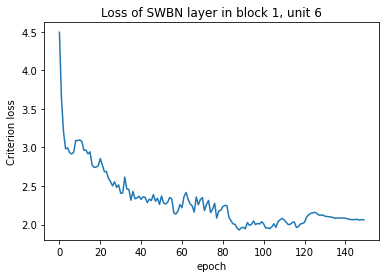

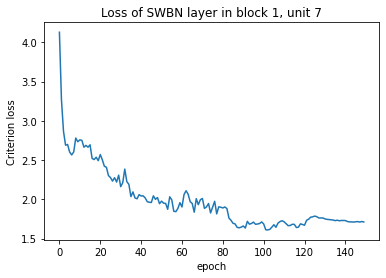

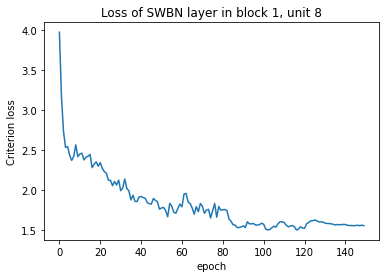

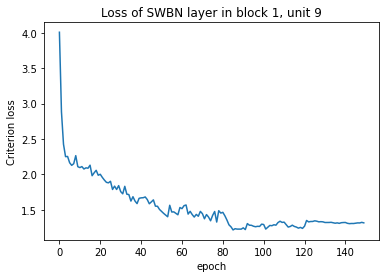

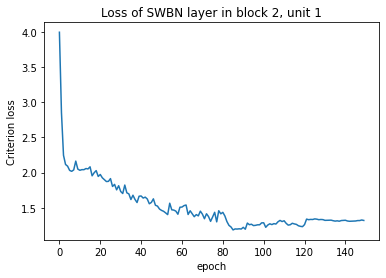

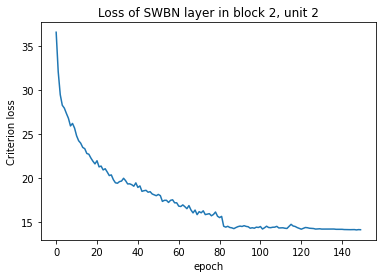

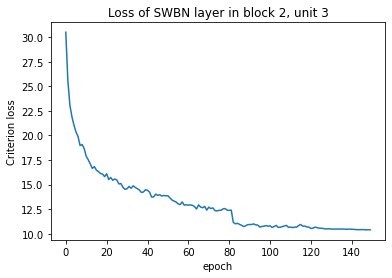

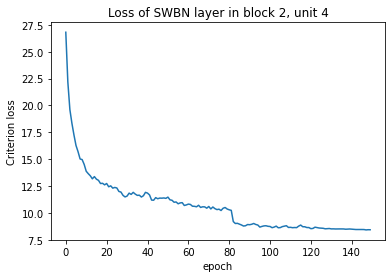

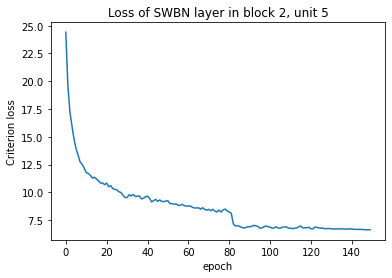

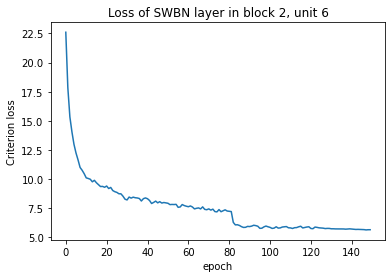

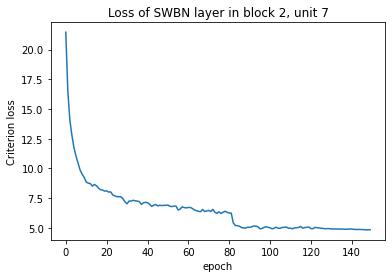

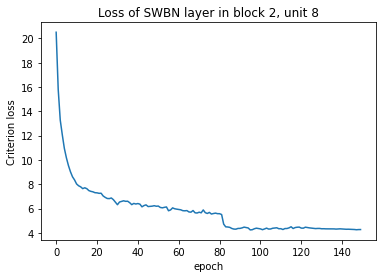

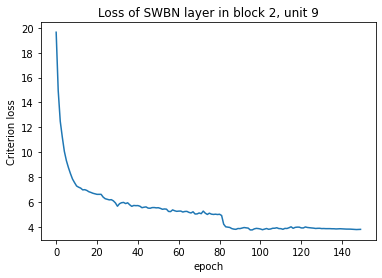

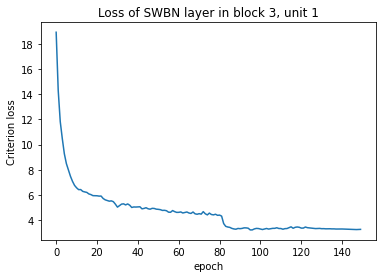

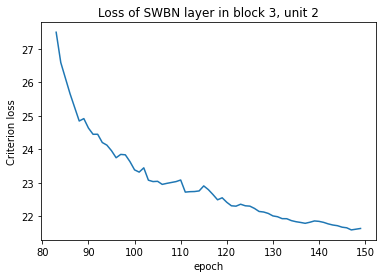

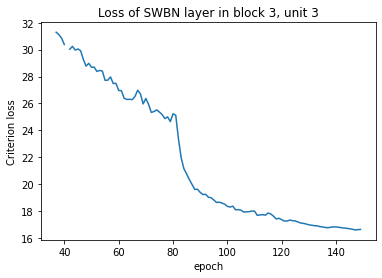

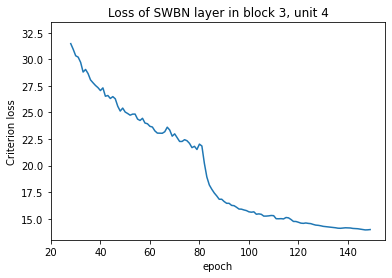

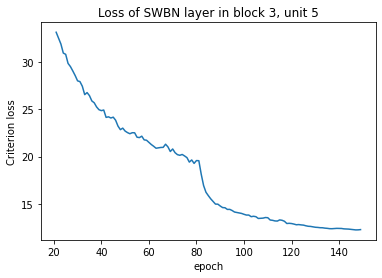

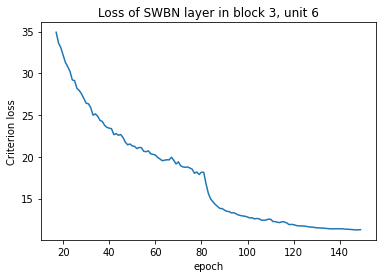

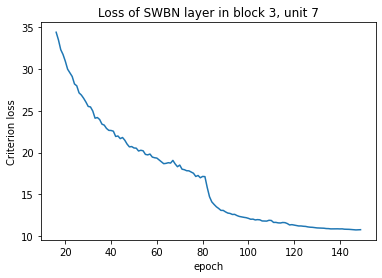

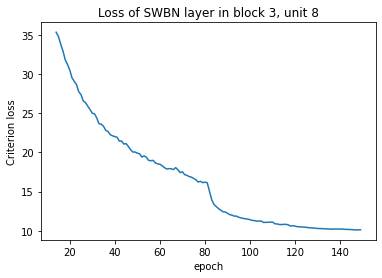

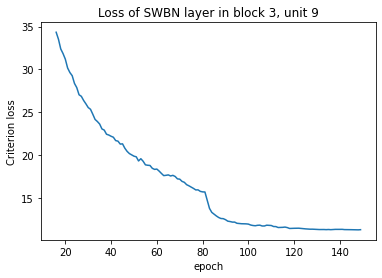

In [11]:
def avg_per_epoch(y):
  chunk=[]
  x=[]
  for idx,n in enumerate(y):
    chunk.append(n)
    if (idx+1)%391 == 0: #391 is the number of iterations in one epoch
      mean = np.mean(chunk)
      x.append(mean)
      chunk.clear()
  return x

num_block=0
resnet56.model().summary()
for layer in resnet56.layers:
  if "resnet" in layer.name:
    num_block+=1
    for num_unit,res_layers in enumerate(layer.layers):
      y = res_layers._bns[0].train_loss.numpy().squeeze()[1:] #can use either _bns[0] or _bns[1]
      x = avg_per_epoch(y)
      plt.plot(x)
      plt.title(f'Loss of SWBN layer in block {num_block}, unit {num_unit+1}')
      plt.ylabel('Criterion loss')
      plt.xlabel('epoch')
      plt.show()